In [1]:
from skopt import gp_minimize
from scipy.stats import gmean
import numpy as np
import subprocess
import json

In [2]:
def score_from_json(res):
    l = [test['metrics']['Score']['current'][0] for test in res['JetStream2.0']['tests'].values()]
    return gmean(l)

def run_jetstream2(host, ssh_id=None, jscpath=None, env=None):
    """Assumes JetStream2 is in `JetStream2/` path on `host`."""

    def __parse(s, errs=None):
        for line in s.splitlines():
            if line.startswith('{'):
                return json.loads(line)
        raise RuntimeError(f"Could not parse JetStream2 output:\n{s}\nstderr:\n{errs}\n")

    if env is None:
        envs = ""
    else:
        envs = " ".join(f"JSC_{k}={v}" for k,v in env.items())
    if jscpath is None:
        jscpath = 'jsc'
    ssh_opts = "-o StrictHostKeyChecking=no"
    if ssh_id:
        ssh_opts += f" -i {ssh_id}"
    cmd = f'ssh {ssh_opts} {host} "cd JetStream2; {envs} {jscpath} watch-cli.js"'
    def __run():
        proc = subprocess.run(cmd, shell=True, text=True, capture_output=True, check=True)
        json_res = __parse(proc.stdout, proc.stderr)
        return score_from_json(json_res)
    return np.mean([__run() for _ in range(3)])

#json_res = run_jetstream2('test@repichoca', 'ssh/id_rsa', '/home/test/jsc')

In [3]:


#score_from_json(json_res)

In [4]:
from collections import namedtuple
Parameter = namedtuple('Parameter', ('name', 'range'))
parameters = (Parameter('maximumFunctionForCallInlineCandidateBytecodeCost', (0, 200)),
              Parameter('maximumOptimizationCandidateBytecodeCost', (0, 200000)))


In [5]:
def optimize_me(args):
    assert len(args) == len(parameters)
    env = dict((parameters[i].name, arg) for i, arg in enumerate(args))
    #print(f"running: {env}")
    score = run_jetstream2('test@repichoca', 'ssh/id_rsa', '/home/test/jsc', env=env)
    print(f"optimize_me({args}) → {score}")
    return -score

In [7]:
import time
print ("Starting to minimize")
before = time.monotonic()
res = gp_minimize(optimize_me, [p.range for p in parameters], n_calls=10)
time.monotonic() - before

Starting to minimize
optimize_me([47, 105028]) → 195.2074949643569
optimize_me([167, 170952]) → 197.1336856278514
optimize_me([80, 75014]) → 202.95949129338706
optimize_me([117, 188787]) → 203.94064778472344
optimize_me([174, 12818]) → 199.43895615334722
optimize_me([97, 31624]) → 201.51617662615448
optimize_me([102, 103373]) → 203.85274734334257
optimize_me([193, 135522]) → 193.4048880729838
optimize_me([169, 124209]) → 202.48633371247107
optimize_me([156, 33591]) → 195.6877904219341


572.0381518159993

In [9]:
res.x, -res.fun

([117, 188787], 203.94064778472344)

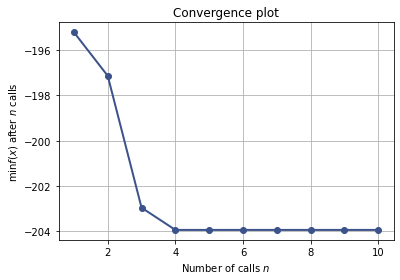

In [10]:
from skopt.plots import plot_convergence, plot_gaussian_process, plot_objective
axes = plot_convergence(res)

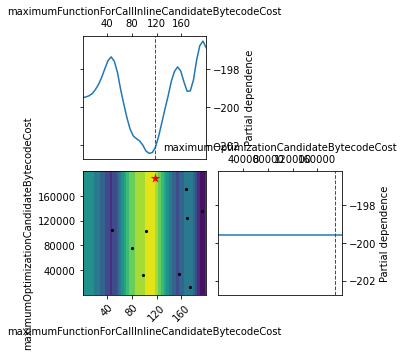

In [11]:
axes = plot_objective(res, dimensions=[p.name for p in parameters])

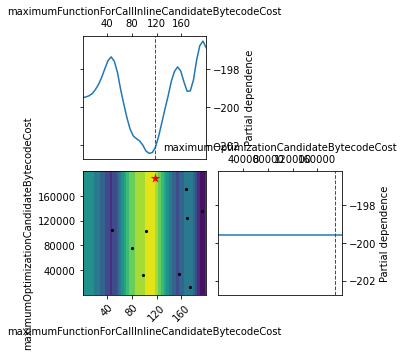

In [24]:
axes[0][0].get_figure()

In [ ]:
fig.savefig('test.png')

In [ ]:
from datetime import datetime
datetime.now().strftime('%Y-%m-%d-%H%M%S')